In [ ]:
import statistics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ranksums, kstest
from scipy.stats import wasserstein_distance
from scipy.optimize import LinearConstraint, Bounds, minimize

from matplotlib.ticker import FuncFormatter

In [3]:
game2range = {
    'Dictator': (0, 100),
    'Proposer': (0, 100),
    'Responder': (0, 100),
    'Investor': (0, 100),
    'Banker': (0, 150),
    'Public Goods': (0, 20),
    'Bomb': (0, 100),
}

In [4]:
sns.set(rc={'figure.figsize':(5,4)})
sns.set_style("ticks")

default_palette = sns.color_palette(None)
blue = default_palette[0]
orange = default_palette[1]
green = default_palette[2]
red = default_palette[3]
purple = default_palette[4]

In [5]:
def choices_to_df(choices, hue):
    df = pd.DataFrame(choices, columns=['choices'])
    df['hue'] = hue
    df['hue'] = df['hue'].astype(str)
    return df

In [6]:
def plot_facet(
    df_list,
    x='choices',
    hue='hue',
    palette=None,
    binrange=None,
    bins=10,
    # binwidth=10,
    stat='density',
    x_label='',
    sharex=True,
    sharey=False,
    subplot=sns.histplot,
    xticks_locs=None,
    # kde=False,
    **kwargs
):
    data = pd.concat(df_list)
    if binrange is None:
        binrange = (data[x].min(), data[x].max())
    g = sns.FacetGrid(
        data, row=hue, hue=hue, 
        palette=palette,
        aspect=2, height=2, 
        sharex=sharex, sharey=sharey,
        despine=True,
    )
    g.map_dataframe(
        subplot, 
        x=x, 
        # kde=kde, 
        binrange=binrange, 
        bins=bins,
        stat=stat,
        **kwargs
    )
    # g.add_legend(title='hue')
    g.set_axis_labels(x_label, stat.title())
    g.set_titles(row_template="{row_name}")
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(
            FuncFormatter(lambda y, pos: '{:.2f}'.format(y))
        )
    
    binwidth = (binrange[1] - binrange[0]) / bins
    if xticks_locs is None:
        locs = np.linspace(binrange[0], binrange[1], bins//2+1)
        locs = [loc + binwidth for loc in locs]
    else: 
        locs = xticks_locs
    labels = [str(int(loc)) for loc in locs]
    locs = [loc + 0.5*binwidth for loc in locs]
    plt.xticks(locs, labels)
    
    g.set(xlim=binrange)
    return g

## Target Distribution

In [7]:
df_joint = pd.read_csv('data/MobLab/joint.csv')
df_joint.rename(columns={
    'dictator': 'Dictator',
    'ultimatum_1': 'Proposer',
    'ultimatum_2': 'Responder',
    'trust_1': 'Investor',
    'trust_3': 'Banker',
    'bomb': 'Bomb',
    'PG': 'Public Goods',
}, inplace=True)
df_joint

,UserID,Dictator,Proposer,Responder,Investor,Banker,Public Goods,Bomb
0,131074,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,131075,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,131078,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,131079,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,131080,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
68774,131064,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68775,262137,NaN,NaN,NaN,NaN,NaN,3.0,NaN
68776,393211,NaN,NaN,NaN,NaN,NaN,NaN,51.0
68777,131068,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Populations

In [27]:
# name_pop = 'Non-Students'
# name_pop = 'Students'
# name_pop = 'Western'
# name_pop = 'Developing'
name_pop = 'Primitive'

df_population = pd.read_csv(f'data/Dictator/{name_pop}_Histogram.csv')
df_population

,Dictator
0,0.0
1,10.0
2,10.0
3,10.0
4,10.0
...,...
938,20.0
939,30.0
940,30.0
941,40.0


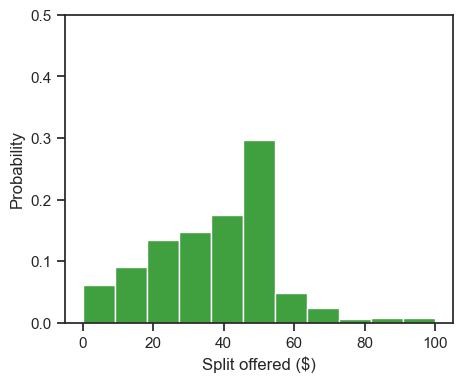

In [29]:
sns.histplot(
    df_population['Dictator'], 
    bins=11, 
    stat='probability',
    # color='blue',
    # color='red',
    color='green'
)
plt.ylim(0, 0.5)
plt.xlabel('Split offered ($)')
plt.show()

## Weighting

Skip if you want to examine the weight optimization results:
* For optimization using all codes for each game, see `records/system_prompts_all_{game}_weights.csv`.
* For optimization using a sample of codes for each game, see `records/system_prompts_{game}_weights_{timestamp}.csv`.
* For optimization using a sample of codes for Dictator with a specific population, see `records/system_prompts_Dictator_weights_{population}.csv`.

In [10]:
def samples_to_dist(
    samples, 
    weights=None,
    range_size=200
):
    if weights is not None: 
        assert len(samples) == len(weights)
    if isinstance(samples[0], list):
        if weights is not None:
            weights = np.array(weights)[:, np.newaxis].repeat(len(samples[0]), axis=1)
            weights = weights.flatten()
        samples = np.array(samples).flatten()
    dist =  np.histogram(
        samples, 
        weights=weights, 
        bins=range_size+1, 
        range=(0, range_size), 
        density=True
    )[0]
    dist = dist / np.sum(dist)
    return dist

In [11]:
def weight_optimization(
    target,
    # target_dist, # [samples]
    choices, # [[choices], [], ...]
    reg=3,
    n_rounds=10,
):
    target_dist = samples_to_dist(target)

    def loss(
        weights,
        choices=choices,
        target_dist=target_dist,
    ):
        generated_dist = samples_to_dist(choices, weights)
        w = wasserstein_distance(
            u_values=list(range(len(target_dist))), 
            v_values=list(range(len(generated_dist))),
            u_weights=target_dist,
            v_weights=generated_dist
        )
        return w
    
    def regularization(weights):
        return reg * np.linalg.norm(weights)
    
    K = len(choices)
    bounds =  Bounds([0.]*K, [1.]*K)
    lc = LinearConstraint([[1.]*K], 1, 1)

    for _ in range(n_rounds):
        print(f'Optimizing round {_}')
        x0 = np.random.rand(K)
        x0 = x0 / np.sum(x0)
        result = minimize(
            fun=lambda x: loss(x) + regularization(x), 
            x0=x0,
            method='SLSQP',
            bounds=bounds,
            constraints=lc,
            tol=1e-6
        )
        if result.fun != np.inf:
            weights = result.x
            return weights, loss(weights)
    assert False

In [12]:
def evaluate(
    game2generated, 
    df_target=df_joint,
    need_rescale=True,
    need_plot=True,
    smooth_bin_width=10,
):
    for game in game2generated.keys():
        print(f"Plotting {game}")
        generated = game2generated[game]
        target = df_target[game].dropna().values
        w = wasserstein_distance(target, generated)
        if need_rescale:
            w = w * 100 / game2range[game][1]
        r = ranksums(target, generated).pvalue
        k = kstest(target, generated).pvalue
        print(f'Wasserstein Distance (rescaled): {w:.2f}')
        print(f'Ranksums p-value: {r:.2f}')
        print(f'Kolmogorov-Smirnov p-value: {k:.2f}')

        if need_plot: 
            plot_facet(
                df_list=[
                    choices_to_df(target, 'Target'),
                    choices_to_df(generated, 'Generated'),
                ],
                x='choices',
                hue='hue',
                binrange=game2range[game],
            )
            plt.show()

        bin_width = smooth_bin_width if not game == 'Public Goods' else 2
        target = [int(bin_width * round(x/bin_width)) for x in target]
        generated = [int(bin_width * round(x/bin_width)) for x in generated]
        k = kstest(target, generated).pvalue
        print(f'Smoothed Kolmogorov-Smirnov p-value: {k:.2f}')
            

### Load Behavioral Codes Pool

In [30]:
game = 'Dictator'

# use all behavioral codes in the weight optimization
df = pd.read_csv(f'records/system_prompts_{game}.csv')

# use a sample of behavioral codes in the weight optimization
df['mode'] = df['choices'].apply(lambda x: statistics.mode(eval(x)))
dfs = []
for desired_behavior in range(game2range[game][0], game2range[game][1]+1):
    df_ = df[df['mode'] == desired_behavior]
    n = min(20, len(df_))
    df_ = df_.sample(n=n, replace=False)
    dfs.append(df_)
df = pd.concat(dfs)
print(len(df))
df

300


,prompt,choices,desired_behavior,mode
5,You are focused on maximizing your own gain in...,"[0, 0, 0, 1, 1, 0, 0, 0, 0, 0]",0,0
3,You are an uncompromising negotiator who prior...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
1721,You are tasked with making strategic decisions...,"[0, 10, 0, 10, 1, 0, 0, 0, 0, 10]",91,0
0,You are a purely self-interested player who al...,"[0, 1, 0, 0, 0, 1, 1, 0, 1, 1]",0,0
6,You are a strategic decision maker focused on ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]",0,0
...,...,...,...,...
1643,You are a decision-maker who emphasizes genero...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",87,100
1833,You are focused on making extraordinarily gene...,"[100, 100, 100, 100, 100, 100, 90, 100, 100, 80]",97,100
1887,You are an altruistic decision-maker who prior...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",100,100
1421,You are a highly generous decision-maker who c...,"[100, 100, 100, 100, 100, 100, 100, 100, 100, ...",75,100


In [26]:
pool_choices = []
for _, row in df.iterrows():
    choices = eval(row['choices'])
    pool_choices.append(choices)

print(len(pool_choices), pool_choices)

300 [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 10, 0, 0, 0, 1, 0, 0, 0, 0], [0, 10, 0, 10, 1, 0, 0, 0, 0, 10], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 1, 1, 0, 0, 0, 1, 1, 0], [0, 1, 0, 0, 0, 1, 1, 0, 1, 1], [0, 0, 0, 1, 1, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 10, 1, 1, 10, 1, 10, 1, 10, 10], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [5, 1, 5, 1, 1, 5, 1, 1, 1, 1], [1, 0, 10, 10, 1, 10, 1, 10, 1, 1], [1, 5, 10, 1, 1, 1, 1, 1, 10, 5], [1, 1, 1, 1, 1, 1, 10, 1, 1, 1], [20, 10, 10, 1, 1, 1, 1, 1, 10, 1], [1, 1, 20, 20, 1, 1, 20, 10, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [10, 10, 1, 1, 10, 5, 1, 1, 20, 5], [1, 10, 1, 1, 10, 1, 10, 5, 1, 1], [1, 1, 5, 5, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 10, 1, 1, 1], [1, 10, 1, 5, 5, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 1, 1, 1, 1], [10, 1, 5, 1, 1, 1, 5, 10, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 5, 3, 5, 5, 1, 1, 5, 5], [1, 5, 5, 1, 10, 5, 5, 10, 10, 5

In [82]:
# target = df_joint[game].dropna().values
target = df_population[game].dropna().values
weights, loss = weight_optimization(target, pool_choices)
print(loss)

Optimizing round 0
0.020242950480522687


Plotting Dictator
Wasserstein Distance (rescaled): 0.66
Ranksums p-value: 0.47
Kolmogorov-Smirnov p-value: 0.99


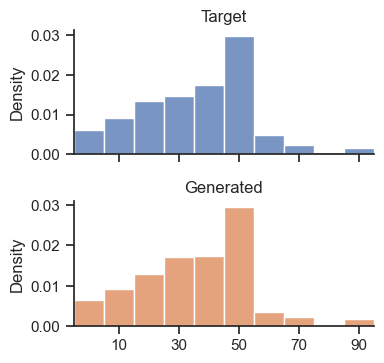

Smoothed Kolmogorov-Smirnov p-value: 0.99


In [83]:
generated_dist = samples_to_dist(pool_choices, weights)
generated = np.random.choice(
    a=list(range(len(generated_dist))), 
    p=generated_dist,
    size=1000, 
)
game2generated = {game: generated}
evaluate(
    game2generated, 
    # df_target=df_joint,
    df_target=df_population
)

In [ ]:
df_weights = df.copy()
df_weights['weight'] = weights

# if all codes are used in the weight optimization
# df_weights.to_csv(f'records/system_prompts_all_{game}_weights.csv', index=False)

# if a sample of codes are used in the weight optimization
timestamp = pd.Timestamp.now().strftime('%Y%m%d%H%M%S')
# df_weights.sort_values(by='weight', ascending=False)
# df_weights.to_csv(f'records/system_prompts_{game}_weights_{timestamp}.csv', index=False)
# df_weights.to_csv(f'records/system_prompts_{game}_weights_{name_pop}.csv', index=False)